In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# training CNN using pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
hd5_1 ="/kaggle/input/chunk1/chunk1.hdf5"
csv_file_1 = "/kaggle/input/chunk1/chunk1.csv"
hdf5_2 =  "/kaggle/input/stead-chunk-2/chunk2.hdf5"
csv_file_2 = "/kaggle/input/stead-chunk-2/chunk2.csv"
chunk_1 = pd.read_csv(csv_file_1)
chunk_2 = pd.read_csv(csv_file_2)
full_csv = pd.concat([chunk_1,chunk_2])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
full_csv.head()

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 00:17:30,noise,113A.AE_20180115001730_NO
1,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 00:33:36,noise,113A.AE_20180115003336_NO
2,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 02:01:06,noise,113A.AE_20180115020106_NO
3,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 02:29:06,noise,113A.AE_20180115022906_NO
4,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 03:51:00,noise,113A.AE_20180115035100_NO


In [ ]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

#Check for missing values
print('Number of missing values:', df.isnull().sum().sum())

In [7]:
num_cols = ['receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
            'p_weight', 'p_travel_sec', 's_arrival_sample', 's_weight', 'source_origin_uncertainty_sec',
            'source_latitude', 'source_longitude', 'source_error_sec', 'source_gap_deg',
            'source_horizontal_uncertainty_km', 'source_depth_km', 'source_depth_uncertainty_km',
            'source_magnitude', 'source_distance_deg', 'source_distance_km', 'back_azimuth_deg',
            'snr_db', 'coda_end_sample']

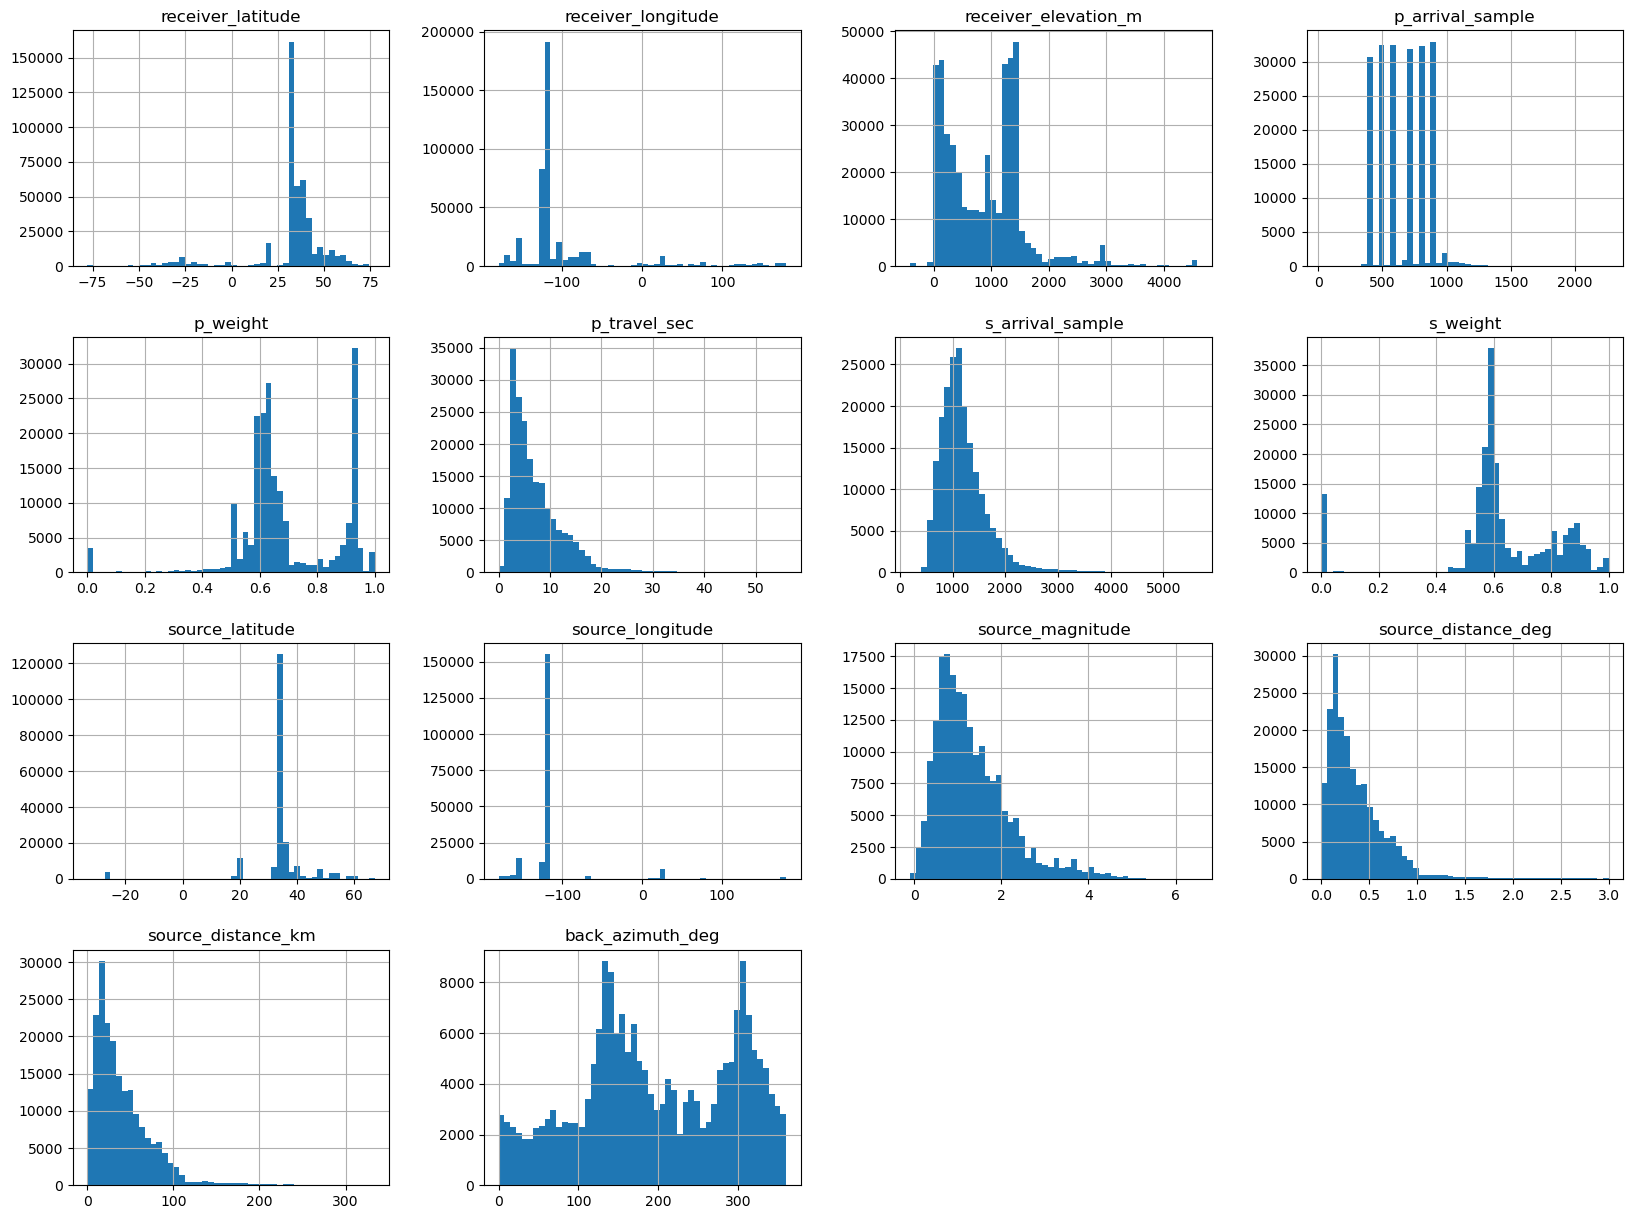

<Figure size 640x480 with 0 Axes>

In [8]:
full_csv[num_cols].hist(bins=50, figsize=(20,15))
plt.show()
plt.savefig('histogram' +'.png')

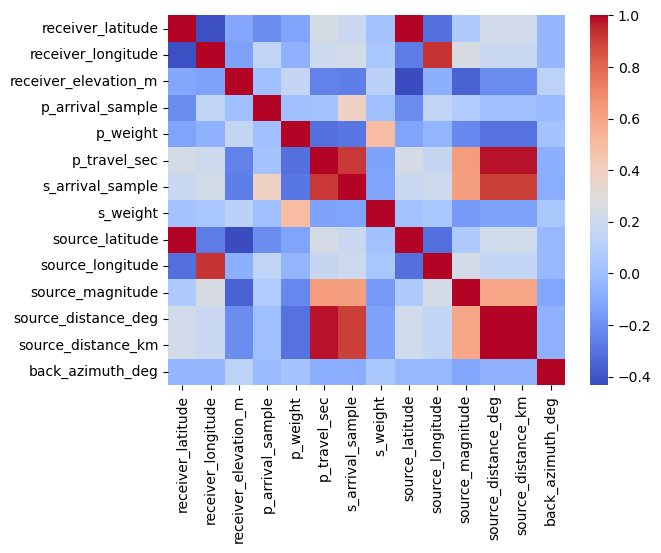

<Figure size 640x480 with 0 Axes>

In [9]:
import seaborn as sns
# Check the correlation between numerical columns
corr_matrix = full_csv[num_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()
plt.savefig('co_rel' + '.png')

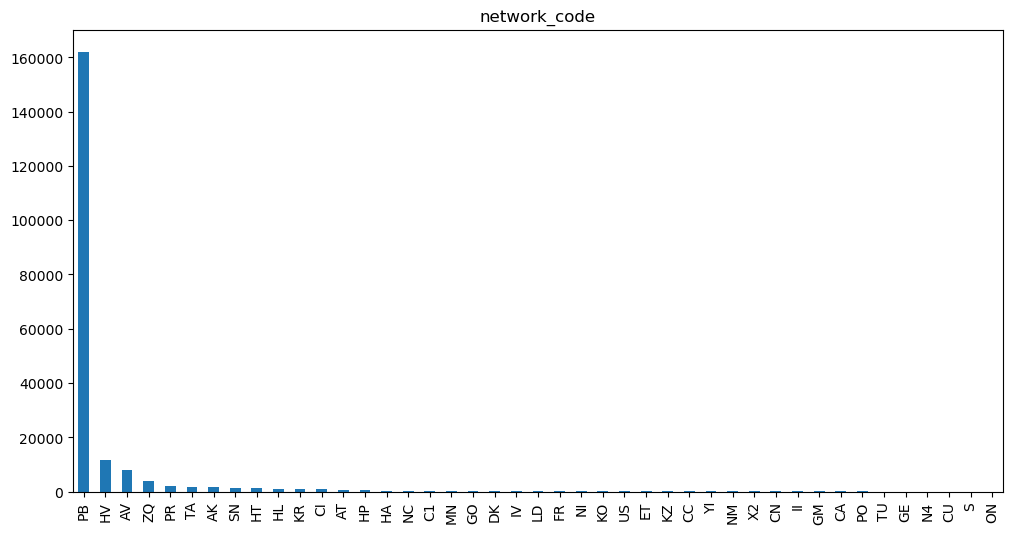

<Figure size 640x480 with 0 Axes>

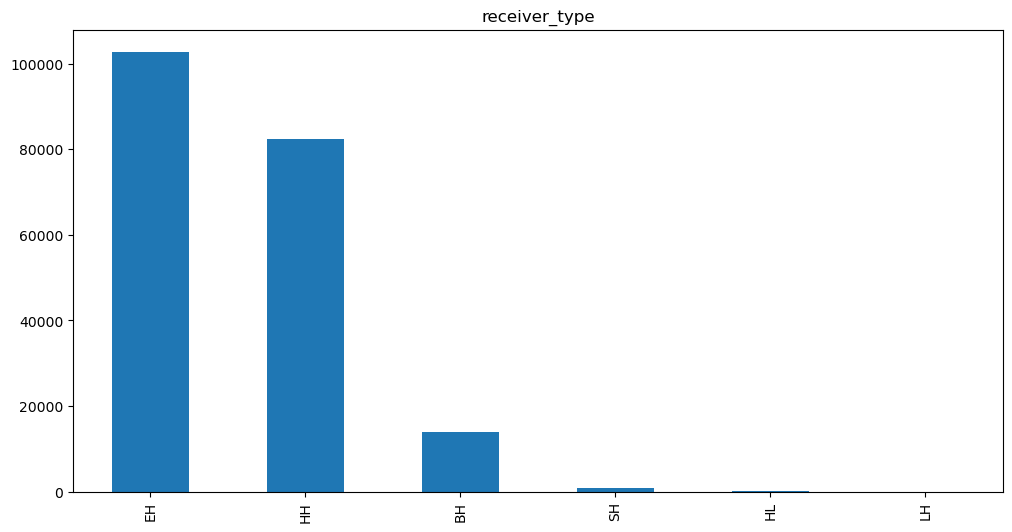

<Figure size 640x480 with 0 Axes>

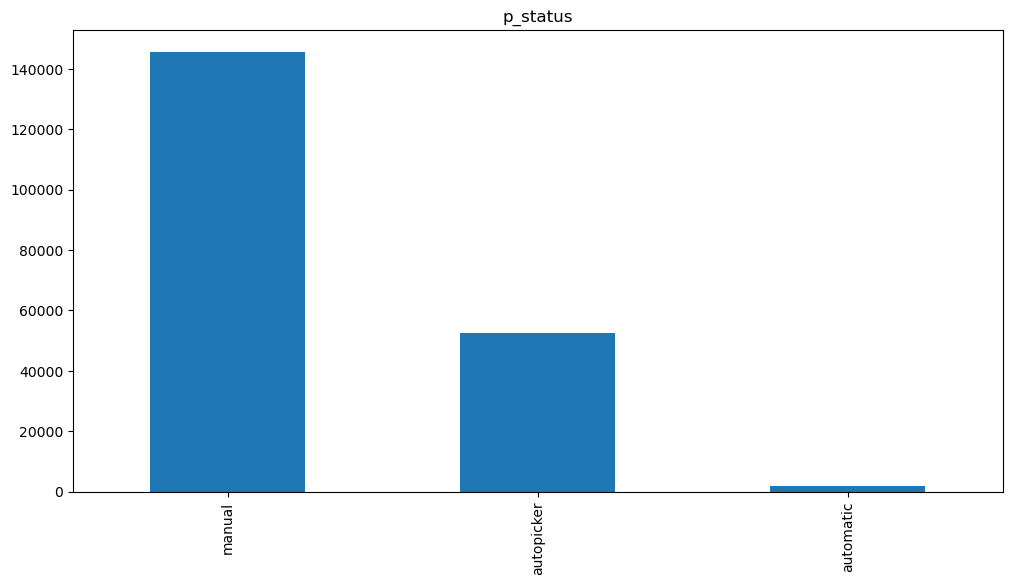

<Figure size 640x480 with 0 Axes>

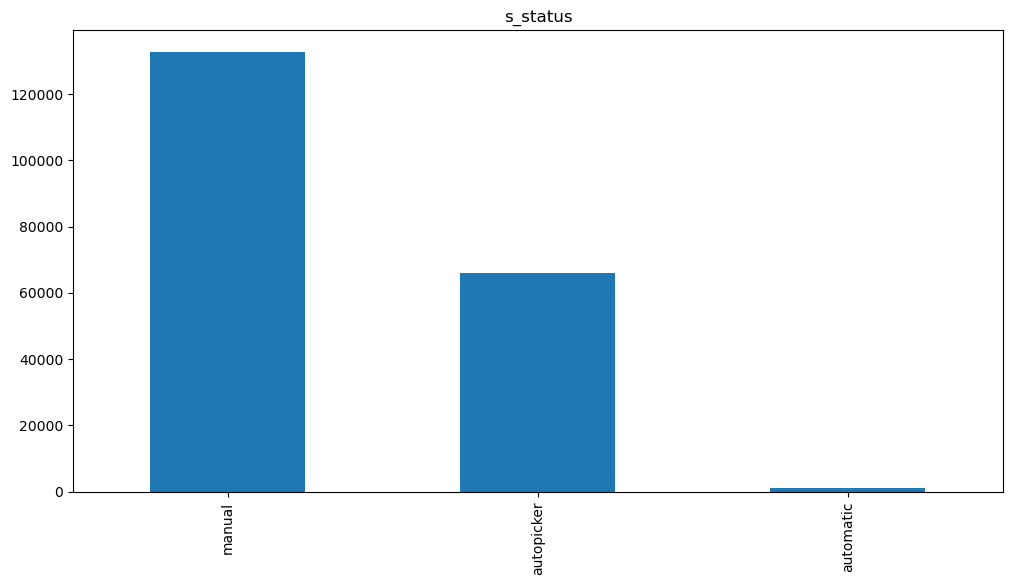

<Figure size 640x480 with 0 Axes>

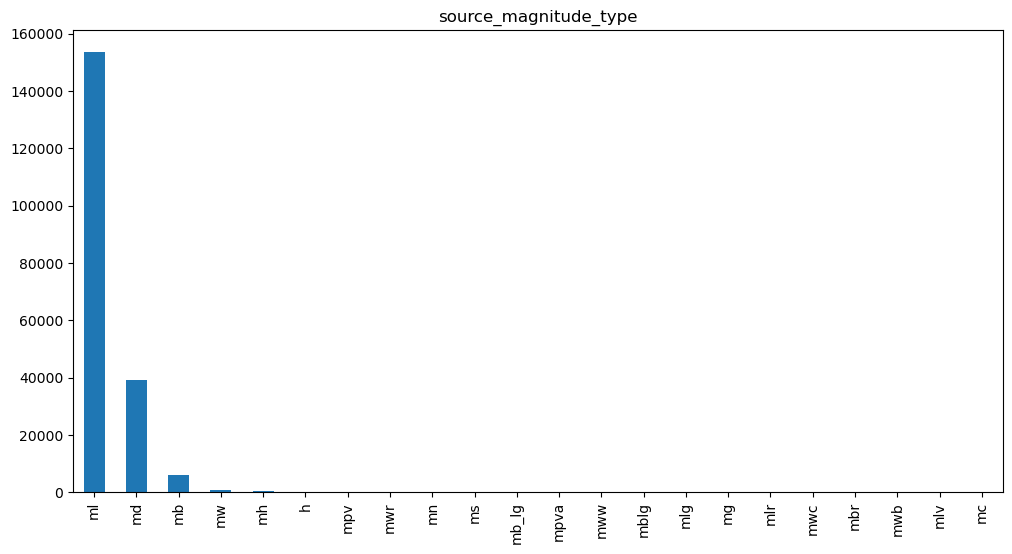

<Figure size 640x480 with 0 Axes>

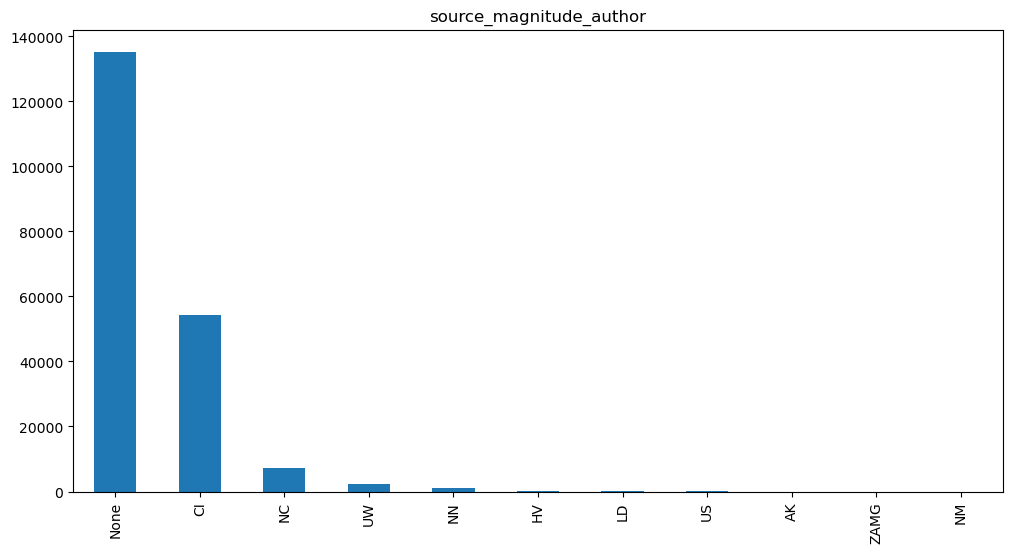

<Figure size 640x480 with 0 Axes>

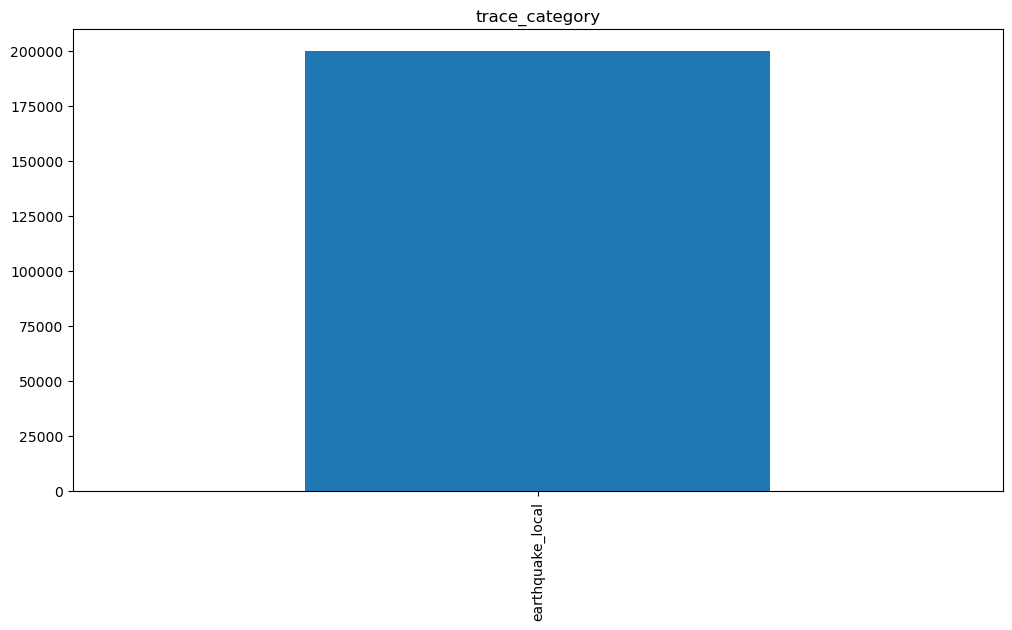

<Figure size 640x480 with 0 Axes>

In [7]:
# Check the distribution of categorical columns
cat_cols = ['network_code', 'receiver_type', 'p_status', 's_status',
            'source_magnitude_type', 'source_magnitude_author', 'trace_category']
for col in cat_cols:
    plt.figure(figsize=(12,6))
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
    plt.savefig(col + '.png')

In [11]:
# Print the cleaned dataset
print('Cleaned dataset:')
df.head()
print(f"Shape: {df.shape}")

Cleaned dataset:
Shape: (126523, 35)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import cv2

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime
from joblib import Parallel,delayed

from scipy import signal
from scipy.signal import resample,hilbert
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [13]:
def waveform_spectrogram_plot(signal_path,signal_index,signal_list):
    dtfl = h5py.File(signal_path, 'r') # find the signal file
    dataset = dtfl.get('data/'+str(signal_list[signal_index])) # fetch one signal from the file
    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel
    data = np.array(dataset)

    # plot
    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9,7))
    ax1.plot(np.linspace(0,60,6000),data[:,2],color='k',linewidth=1) # plot waveform
    ymin, ymax = ax1.get_ylim()
    ax1.vlines(dataset.attrs['p_arrival_sample']/100,ymin,ymax,color='b',linewidth=1.5, label='P-arrival') # plot p-wave arrival time
    ax1.vlines(dataset.attrs['s_arrival_sample']/100, ymin, ymax, color='r', linewidth=1.5, label='S-arrival') # plot s-wave arrival time
    ax1.vlines(dataset.attrs['coda_end_sample']/100, ymin, ymax, color='cyan', linewidth=1.5, label='Coda end')
    ax1.set_xlim([0,60])
    ax1.legend(loc='lower right',fontsize=10)
    ax1.set_ylabel('Amplitude (counts)')
    ax1.set_xlabel('Time (s)')
    im = ax2.specgram(data[:,2],Fs=100,NFFT=256,cmap='jet',vmin=-10,vmax=25); # plot spectrogram
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_xlabel('Time (s)')
    ax3.psd(data[:,2],256,100,color='cornflowerblue') # plot power spectral density
    ax3.set_xlim([0,50])
    plt.savefig('waveform_spectrogram_plot.png',dpi=500)
    plt.tight_layout()
    plt.show()

    print('The p-wave for this waveform was picked by: ' + dataset.attrs['p_status'])
    print('The s-wave for this waveform was picked by: ' + dataset.attrs['s_status'])

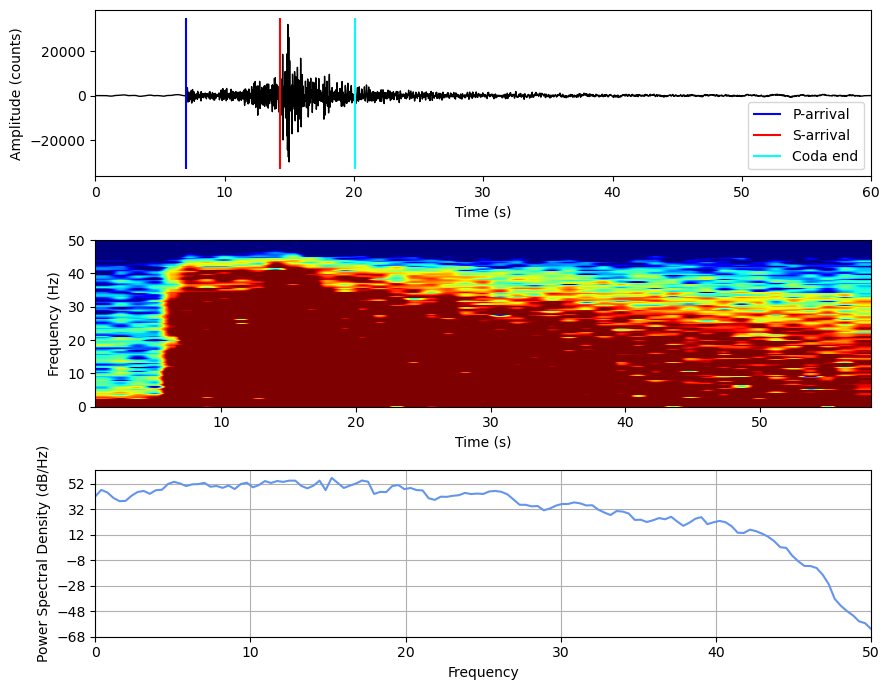

The p-wave for this waveform was picked by: manual
The s-wave for this waveform was picked by: manual


In [14]:
waveform_spectrogram_plot(file_name,12000,df['trace_name'].to_list())

In [15]:
import shutil
import os

source_folder = '/kaggle/input/cnn-img/kaggle/working/'
destination_folder = '//kaggle/working/images/'

# Make sure the destination folder exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy all the files from the source folder to the destination folder
for file_name in os.listdir(source_folder):
    shutil.copy(os.path.join(source_folder, file_name), destination_folder)


In [23]:
dir = '/kaggle/working/images'


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import cv2

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime
from joblib import Parallel,delayed

from scipy import signal
from scipy.signal import resample,hilbert
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


#######################################################################


class SeismicCNN():

    def __init__(self,model_type,target,choose_dataset_size,full_csv,dir):
        self.model_type = model_type
        self.target = target
        self.choose_dataset_size = choose_dataset_size
        self.full_csv = full_csv
        self.dir = dir
        self.traces_array = []
        self.img_dataset = []
        self.labels = []
        self.imgs = []
        self.train_images = []
        self.train_labels = []
        self.test_images = []
        self.test_labels = []
        self.model = []
        self.test_loss = []
        self.test_acc = []
        self.predicted_classes = []
        self.predicted_probs = []
        self.cm = []
        self.epochs = []
        self.history = []

      
        if self.model_type == 'classification':
            # create list of traces in the image datset
            print('Creating seismic trace list')
            for filename in os.listdir(dir): # loop through image directory and get filenames
                if filename.endswith('.png'):
                    self.traces_array.append(filename[0:-4]) # remove the .png from filename

            if choose_dataset_size == 'full':
                # select only the rows in the metadata dataframe which correspond to images
                print('Selecting traces matching images in directory')
                self.img_dataset = self.full_csv.loc[self.full_csv['trace_name'].isin(self.traces_array)] # select rows from the csv that have matching image files
                self.labels = self.img_dataset['trace_category'] # target variable, 'earthquake' or 'noise'
                self.labels = np.array(self.labels.map(lambda x: 1 if x == 'earthquake_local' else 0)) # transform target variable to numerical categories
                print(f'The number of traces in the directory is {len(self.img_dataset)}')
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through images and read them into the imgs array
                    count += 0
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(self.dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    self.imgs.append(img)
                self.imgs = np.array(self.imgs)
                imgs.shape
                
            elif type(choose_dataset_size) == int:
                seismic_dataset = self.full_csv.loc[self.full_csv['trace_name'].isin(self.traces_array)] # get rows of csv dataset that have corresponding images in directory
                choose_seismic_dataset = np.random.choice(np.array(seismic_dataset['trace_name']),choose_dataset_size,replace=False)
                self.img_dataset = seismic_dataset.loc[seismic_dataset['trace_name'].isin(choose_seismic_dataset)] # random choice of images from the directory
                self.labels = self.img_dataset['trace_category'] # target variable, 'earthquake' or 'noise'
                self.labels = np.array(self.labels.map(lambda x: 1 if x == 'earthquake_local' else 0)) # transform target variable to numerical categories
                print(f'The number of traces in the directory is {len(self.img_dataset)}')
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through trace names in filtered dataframe and append images to imgs array
                    count += 1
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(self.dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    self.imgs.append(img)
                self.imgs = np.array(self.imgs)
                self.imgs.shape
                
            else:
                print('Error: please choose either "full" for variable choose_dataset_size to use the full dataset, or provide an integer number of random samples to take from the dataset')
                        
        elif self.model_type == 'regression':
        
            for filename in os.listdir(dir): # loop through every file in the directory and get trace names from the image files
                if filename.endswith('.png'):
                    self.traces_array.append(filename[0:-4]) # remove .png from image file names
            print(f'The number of all traces in the directory including noise is {len(self.traces_array)}')
            local_quakes = self.full_csv[self.full_csv['trace_category'] == 'earthquake_local'] # get only signals corresponding to local earthquakes, not noise
            local_quakes_data = local_quakes.loc[local_quakes['trace_name'].isin(self.traces_array)]
            
            if choose_dataset_size == 'full':
                self.img_dataset = local_quakes.loc[local_quakes['trace_name'].isin(self.traces_array)]
                print(f'The number of all earthquakes in the directory excluding noise is {len(self.img_dataset)}')
                self.labels = self.img_dataset[target] # target variable
                
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through the images dataframe and read in the images with matching trace names
                    count += 1
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    imgs.append(img)
                self.imgs = np.array(imgs)
                
            elif type(choose_dataset_size) == int:
            
                choose_local_quakes = np.random.choice(np.array(local_quakes_data['trace_name']),choose_dataset_size,replace=False)
                self.img_dataset = local_quakes_data.loc[local_quakes_data['trace_name'].isin(choose_local_quakes)]
                self.labels = self.img_dataset[self.target] # target variable
                
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through dataframe and read in images corresponding to trace names in data frame
                    count += 1
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    self.imgs.append(img)
                self.imgs = np.array(self.imgs)
                
            else:
                print('Error: please choose either "full" for variable choose_dataset_size to use the full dataset, or provide an integer number of random samples to take from the dataset')
                
        else:
            print('Error: please choose either "classification" or "regression" for CNN model type')
 

    def train_test_split(self,test_size,random_state):
        # train test split on images, 75% training data and 25% testing data
        # check for high acc 
        if(self.model_type=='classification'):
            self.train_images, self.test_images, self.train_labels, self.test_labels = train_test_split(self.imgs,self.labels,random_state=random_state,test_size=test_size, shuffle = True,stratify=self.labels)
        else:
             self.train_images, self.test_images, self.train_labels, self.test_labels = train_test_split(self.imgs,self.labels,random_state=random_state,test_size=test_size, shuffle = True)
            
        print(f'The training images set is size: {self.train_images.shape}')
        print(f'The training labels set is size: {self.train_labels.shape}')
        print(f'The testing images set is size: {self.test_images.shape}')
        print(f'The testing labels set is size: {self.test_labels.shape}')
        
        print('Scaling image intensity')
        self.train_images = self.train_images/255.0 # scale intensity to between 0 and 1
        self.test_images = self.test_images/255.0 # scale intensity to between 0 and 1

        img_height = self.train_images.shape[1] # get height of each image in pixels
        img_width = self.train_images.shape[2] # get width of each image in pixels

        print('Resizing images')
        self.train_images = self.train_images.reshape(-1,img_height,img_width,1) # reshape to input into CNN which requires a 4-tensor
        self.test_images = self.test_images.reshape(-1,img_height,img_width,1) # reshape to input into CNN which requires a 4-tensor

    def classification_cnn(self,epochs):
        self.epochs = epochs
        
        # set callbacks so that the model will be saved after each epoch
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}',
                save_freq='epoch')
        ]

        # build CNN on dataset
        print('Building CNN model')
        
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(32, kernel_size=(5, 5), activation = 'relu', padding = 'same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Flatten(input_shape=(self.imgs.shape[1],self.imgs.shape[2])))
        model.add(keras.layers.Dense(64,activation='relu'))
        model.add(keras.layers.Dense(16,activation='relu'))
        model.add(keras.layers.Dense(2,activation='softmax'))

        opt = keras.optimizers.Adam(learning_rate=1e-6)
        model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')
        self.history = model.fit(self.train_images,self.train_labels,batch_size=64,epochs=epochs,callbacks=callbacks,validation_split=0.2,shuffle=True)

        print(model.summary())
        
        # Set model save path
        saved_model_path = f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}'
        # Save entire model to a HDF5 file
        model.save(saved_model_path)
        
        self.model = model
        
    def regression_cnn(self,target,epochs):
        self.epochs = epochs
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}',
                save_freq='epoch')
        ]

        # build CNN on dataset
        print('Building Regression CNN model')
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(64, kernel_size=(5, 5), activation = 'relu', padding = 'same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.50))
        model.add(keras.layers.Flatten(input_shape=(self.imgs.shape[1],self.imgs.shape[2])))
        model.add(keras.layers.Dense(16,activation='relu'))
        model.add(keras.layers.Dense(1))
        
        opt = keras.optimizers.Adam(learning_rate=1e-5)
        model.compile(optimizer=opt,loss='mse',metrics='accuracy')
        self.history = model.fit(self.train_images,self.train_labels,epochs=epochs,callbacks=callbacks,validation_split=0.2,batch_size=64,shuffle=True)

        print(model.summary())
        
        # Set model save path
        saved_model_path = f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}' # _%H%M%S
        # Save entire model to a HDF5 file
        model.save(saved_model_path)
        
        self.model = model


    def evaluate_classification_model(self):
        print('Evaluating model on test dataset')
        self.test_loss, self.test_acc = self.model.evaluate(self.test_images, self.test_labels, verbose=1) # get model evaluation metrics
        print("\nTest data, accuracy: {:5.2f}%".format(100*self.test_acc))

        print('Finding predicted classes and probabilities to build confusion matrix')
        self.predicted_classes = np.argmax(self.model.predict(self.test_images),axis=-1) # predict the class of each image
        self.predicted_probs = self.model.predict(self.test_images) # predict the probability of each image belonging to a class

        # create confusion matrix
        print('Building confusion matrix')
        self.cm = confusion_matrix(self.test_labels,self.predicted_classes) # compare target values to predicted values and show confusion matrix
        print(self.cm)
        accuracy = accuracy_score(self.test_labels,self.predicted_classes)
        precision = precision_score(self.test_labels,self.predicted_classes)
        recall = recall_score(self.test_labels,self.predicted_classes)
        print(f'The accuracy of the model is {accuracy}, the precision is {precision}, and the recall is {recall}.')

        # plot confusion matrix
        plt.style.use('default')
        disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, display_labels=['not earthquake','earthquake'])
        disp.plot(cmap='Blues', values_format='')
        plt.title(f'Classification CNN Results ({self.epochs} epochs)')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()
        
        # plot accuracy history
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['accuracy'])
        ax.plot(self.history.history['val_accuracy'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_accuracy.png')
        plt.show()
        
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['loss'])
        ax.plot(self.history.history['val_loss'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_loss.png')
        plt.show()
        
    def evaluate_regression_model(self):
        print('Evaluating model on test dataset')
        self.test_loss = self.model.evaluate(self.test_images, self.test_labels, verbose=1)
        print(f'Test data loss: {self.test_loss}')
        
        print('Getting predictions')
        self.predicted = self.model.predict(self.test_images)

        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(7,7))
        ax.scatter(self.test_labels,self.predicted,alpha=0.25)
        point1 = [0,0]
        point2 = [6,6]
        xvalues = [point1[0], point2[0]]
        yvalues = [point1[1], point2[1]]
        ax.plot(xvalues,yvalues,color='blue')
        ax.set_ylabel('Predicted Value',fontsize=14)
        ax.set_xlabel('Observed Value',fontsize=14)
        ax.set_title(f'Regression CNN Results 100k dataset | ({self.epochs} epochs)')
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        plt.tight_layout()
        plt.savefig('true_vs_predicted.png')
        plt.show()

        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['loss'])
        ax.plot(self.history.history['val_loss'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Loss (MSE)')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_loss.png')
        plt.show()




Creating seismic trace list
The number of traces in the directory is 12000
The training images set is size: (9000, 100, 150)
The training labels set is size: (9000,)
The testing images set is size: (3000, 100, 150)
The testing labels set is size: (3000,)
Scaling image intensity
Resizing images
Building CNN model
Epoch 1/80


2023-04-30 08:21:57.497268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 [==============================] - 5s 34ms/step - loss: 0.6336 - accuracy: 0.6649 - val_loss: 0.5278 - val_accuracy: 0.7339
Epoch 2/80
113/113 [==============================] - 3s 30ms/step - loss: 0.4577 - accuracy: 0.7994 - val_loss: 0.4109 - val_accuracy: 0.8344
Epoch 3/80
113/113 [==============================] - 4s 32ms/step - loss: 0.3667 - accuracy: 0.9049 - val_loss: 0.3402 - val_accuracy: 0.9294
Epoch 4/80
113/113 [==============================] - 4s 32ms/step - loss: 0.3103 - accuracy: 0.9374 - val_loss: 0.2923 - val_accuracy: 0.9411
Epoch 5/80
113/113 [==============================] - 3s 31ms/step - loss: 0.2707 - accuracy: 0.9464 - val_loss: 0.2584 - val_accuracy: 0.9444
Epoch 6/80
113/113 [==============================] - 4s 32ms/step - loss: 0.2378 - accuracy: 0.9543 - val_loss: 0.2323 - val_accuracy: 0.9506
Epoch 7/80
113/113 [==============================] - 4s 37ms/step - loss: 0.2153 - accuracy: 0.9599 - val_loss: 0.2127 - val_accuracy: 0.9500
Epoch 8/80

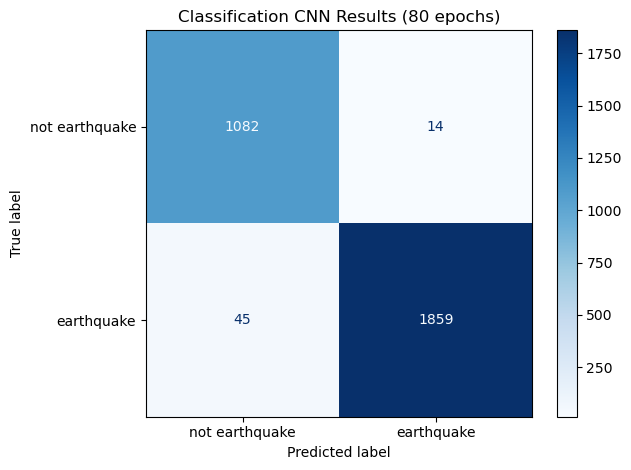

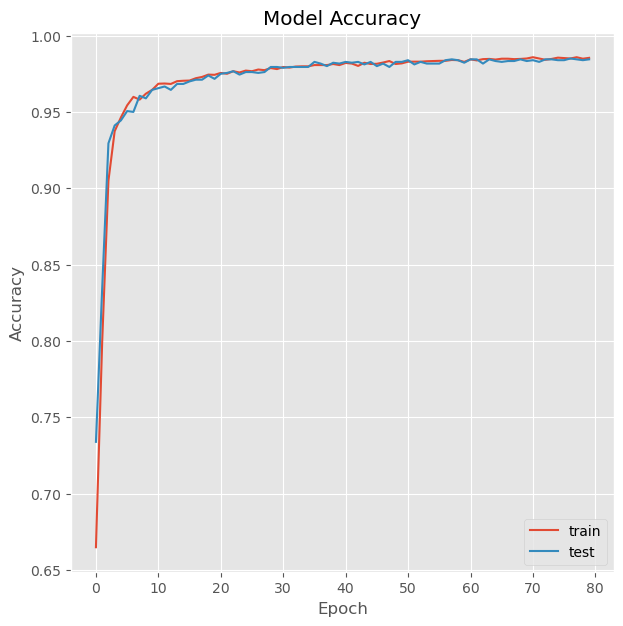

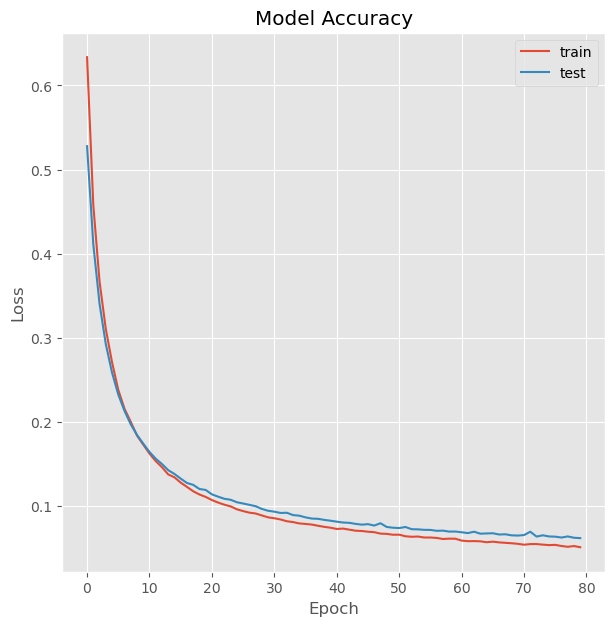

In [21]:
# Using the class for a classification CNN
model_cnn_c1 = SeismicCNN('classification','trace_category',12000,full_csv,dir) # initialize the class
model_cnn_c1.train_test_split(test_size=0.25,random_state=42) # train_test_split
model_cnn_c1.classification_cnn(80) # use the regression cnn method with 15 epochs with a target variable
model_cnn_c1.evaluate_classification_model() # evaluate the model

The number of all traces in the directory including noise is 198621
The training images set is size: (9000, 100, 150)
The training labels set is size: (9000,)
The testing images set is size: (3000, 100, 150)
The testing labels set is size: (3000,)
Scaling image intensity
Resizing images
Building Regression CNN model
Epoch 1/80


2023-04-30 08:31:04.740114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 [==============================] - 8s 53ms/step - loss: 0.5907 - accuracy: 0.0132 - val_loss: 0.2741 - val_accuracy: 0.0122
Epoch 2/80
113/113 [==============================] - 5s 46ms/step - loss: 0.2432 - accuracy: 0.0140 - val_loss: 0.2303 - val_accuracy: 0.0122
Epoch 3/80
113/113 [==============================] - 5s 46ms/step - loss: 0.2202 - accuracy: 0.0140 - val_loss: 0.2151 - val_accuracy: 0.0122
Epoch 4/80
113/113 [==============================] - 5s 46ms/step - loss: 0.2055 - accuracy: 0.0140 - val_loss: 0.2016 - val_accuracy: 0.0122
Epoch 5/80
113/113 [==============================] - 5s 45ms/step - loss: 0.1975 - accuracy: 0.0140 - val_loss: 0.1920 - val_accuracy: 0.0128
Epoch 6/80
113/113 [==============================] - 5s 45ms/step - loss: 0.1867 - accuracy: 0.0140 - val_loss: 0.1905 - val_accuracy: 0.0122
Epoch 7/80
113/113 [==============================] - 5s 48ms/step - loss: 0.1796 - accuracy: 0.0140 - val_loss: 0.1775 - val_accuracy: 0.0122
Epoch 8/80

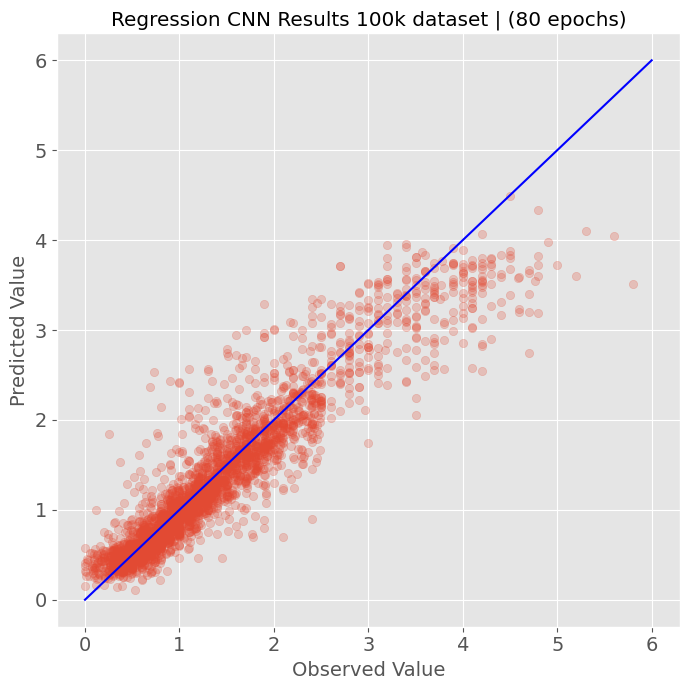

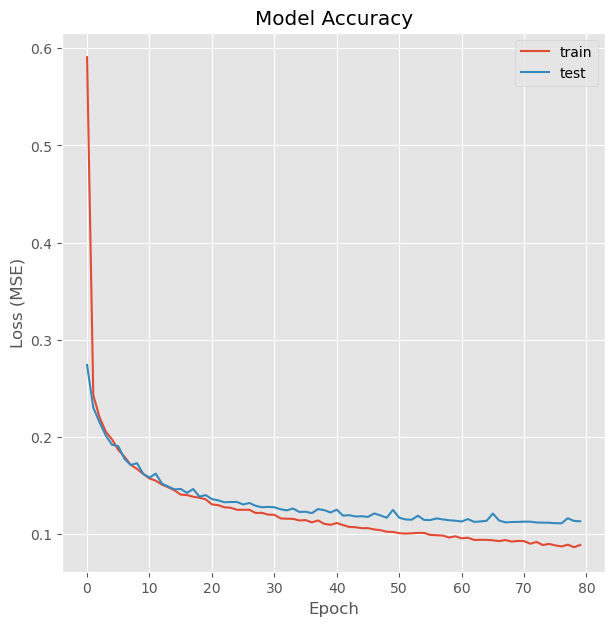

In [24]:
# run the model using CNN regression to predict the earthquake magnitude
model_cnn_rm = SeismicCNN('regression','source_magnitude',12000,full_csv,dir); # initialize the class
model_cnn_rm.train_test_split(test_size=0.25,random_state=42) # train_test_split
model_cnn_rm.regression_cnn('source_magnitude',80) # use the classification cnn method with 15 epochs
model_cnn_rm.evaluate_regression_model() # evaluate the model

The number of all traces in the directory including noise is 198621
The training images set is size: (9000, 100, 150)
The training labels set is size: (9000,)
The testing images set is size: (3000, 100, 150)
The testing labels set is size: (3000,)
Scaling image intensity
Resizing images
Building Regression CNN model
Epoch 1/50


2023-04-30 08:39:40.500977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 [==============================] - 7s 50ms/step - loss: 470461.6250 - accuracy: 0.0000e+00 - val_loss: 455745.8438 - val_accuracy: 0.0000e+00
Epoch 2/50
113/113 [==============================] - 5s 46ms/step - loss: 437529.0625 - accuracy: 0.0000e+00 - val_loss: 413733.4688 - val_accuracy: 0.0000e+00
Epoch 3/50
113/113 [==============================] - 5s 45ms/step - loss: 385253.4688 - accuracy: 0.0000e+00 - val_loss: 351372.7500 - val_accuracy: 0.0000e+00
Epoch 4/50
113/113 [==============================] - 5s 46ms/step - loss: 315180.6562 - accuracy: 0.0000e+00 - val_loss: 276388.1562 - val_accuracy: 0.0000e+00
Epoch 5/50
113/113 [==============================] - 5s 47ms/step - loss: 241540.3750 - accuracy: 0.0000e+00 - val_loss: 207413.5469 - val_accuracy: 0.0000e+00
Epoch 6/50
113/113 [==============================] - 5s 46ms/step - loss: 182628.3125 - accuracy: 0.0000e+00 - val_loss: 159813.4531 - val_accuracy: 0.0000e+00
Epoch 7/50
113/113 [=========================

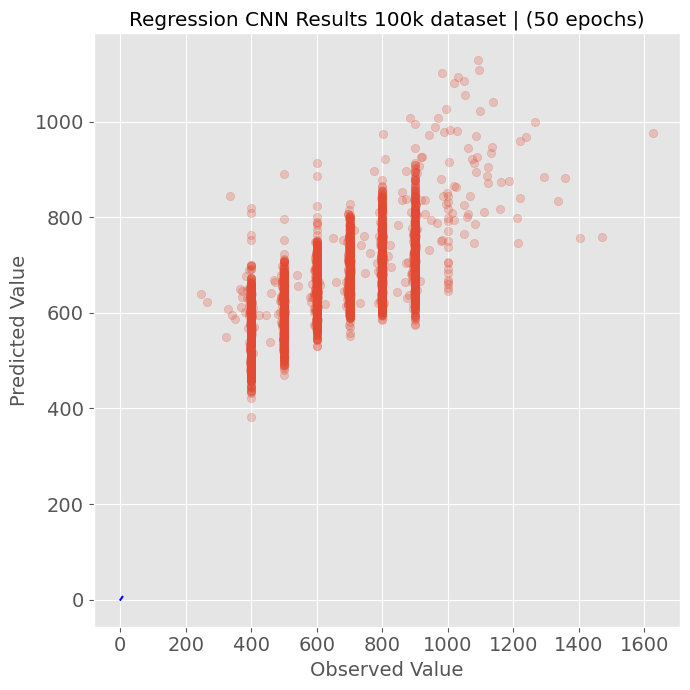

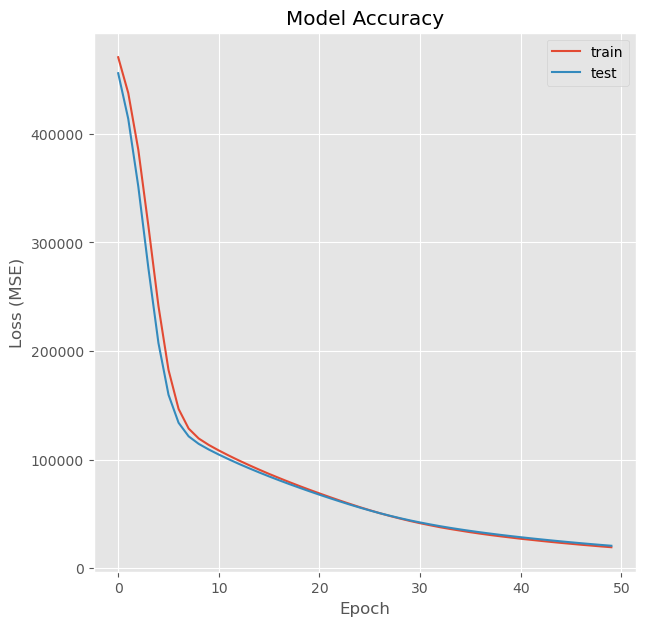

In [25]:
# run the model using CNN regression to predict the p-wave arrival time
model_cnn_rp = SeismicCNN('regression','p_arrival_sample',12000,full_csv,dir); # initialize the class
model_cnn_rp.train_test_split(test_size=0.25,random_state=42) # train_test_split
model_cnn_rp.regression_cnn('p_arrival_sample',50) # use the classification cnn method with 15 epochs
model_cnn_rp.evaluate_regression_model() # evaluate the model
